<a href="https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_intro_2_R_Seurat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to single-cell RNA-seq II: getting started with analysis

This notebook demonstrates pre-processing and basic analysis of the [mouse retinal cells GSE126783](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE126783) dataset from [Koren et al., 2019](https://doi.org/10.1016/j.immuni.2019.02.007). Following pre-processing using kallisto and bustools and basic QC, the notebook demonstrates some initial analysis. The approximate running time of the notebook is 12 minutes.

The notebook was written by Kyung Hoi (Joseph) Min, Lambda Lu, A. Sina Booeshaghi and Lior Pachter. If you use the methods in this notebook for your analysis please cite the following publications which describe the tools used in the notebook, as well as specific methods they run (these are cited inline in the notebook):

* Melsted, P., Booeshaghi, A.S. et al. Modular and efficient pre-processing of single-cell RNA-seq. bioRxiv (2019). doi:10.1101/673285
* McCarthy, D.J., Campbell, K.R., Lun, A.T. and Wills, Q.F. Scater: pre-processing, quality control, normalization and visualization of single-cell RNA-seq data in R (2017). doi.org/10.1093/bioinformatics/btw777

A Python notebook implementing the same analysis is available [here](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_intro_2_python.ipynb). See the [kallistobus.tools tutorials](https://www.kallistobus.tools/tutorials) site for additional notebooks demonstrating other analyses.


## Setup

In [0]:
# This is  used to time the running of the notebook
start_time <- Sys.time()

### Install R packages
There are several packages in R built for scRNA-seq data analysis. Here we use Seurat, which is the most popular of these packages. Examples of other packages are `scater`, which is based on the data structure `SingleCellExperiment`. Bioconductor provides an ebook as a [comprehensive introduction to single cell data analysis](https://osca.bioconductor.org/), with code examples based on `SingleCellExperiment`.

In [2]:
system.time({
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
  BiocManager::install(c('multtest', "DropletUtils"), Ncpus = 2)
  # Seurat was removed from CRAN on Feb 7
  # Install Seurat dependencies with 2 threads
  install.packages(c("ape", "cluster", "cowplot", "fitdistrplus", "future", "future.apply", 
"ggrepel", "ggridges", "httr", "ica", "igraph", "irlba", "leiden", "lmtest", "metap", "pbapply", 
"plotly", "png", "RANN", "RColorBrewer", "RcppAnnoy", "reticulate", 
"rlang", "ROCR", "rsvd", "Rtsne", "scales", "sctransform", "SDMTools", 
"tsne", "uwot", "scico", "ggpointdensity"), Ncpus = 2)
  devtools::install_github("satijalab/Seurat")
})

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.2 (2019-12-12)

Installing package(s) 'BiocVersion', 'multtest', 'DropletUtils'

also installing the dependencies ‘zlibbioc’, ‘bitops’, ‘XVector’, ‘RCurl’, ‘GenomeInfoDbData’, ‘formatR’, ‘GenomicRanges’, ‘GenomeInfoDb’, ‘lambda.r’, ‘futile.options’, ‘matrixStats’, ‘SummarizedExperiment’, ‘futile.logger’, ‘snow’, ‘limma’, ‘locfit’, ‘DelayedArray’, ‘IRanges’, ‘R.oo’, ‘R.methodsS3’, ‘sitmo’, ‘BiocGenerics’, ‘Biobase’, ‘SingleCellExperiment’, ‘S4Vectors’, ‘BiocParallel’, ‘edgeR’, ‘rhdf5’, ‘HDF5Array’, ‘R.utils’, ‘dqrng’, ‘beachmat’, ‘Rhdf5lib’


Old packages: 'curl', 'DT', 'farver', 'jsonlite', 'knitr', 'mime', 'processx',
  'rprojroot', 'rstudioapi', 'svglite', 'xfun', 'xtable', 'nlme'

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘mnormt’, ‘numDeriv’, ‘TH.data’, ‘sandwich’, ‘lsei’,

curl     (4.2   -> 4.3  ) [CRAN]
jsonlite (1.6   -> 1.6.1) [CRAN]
mime     (0.8   -> 0.9  ) [CRAN]
farver   (2.0.1 -> 2.0.3) [CRAN]
xtable   (1.8-3 -> 1.8-4) [CRAN]


Skipping 3 packages ahead of CRAN: multtest, BiocGenerics, Biobase

Installing 5 packages: curl, jsonlite, mime, farver, xtable

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



✔  checking for file ‘/tmp/RtmpQxh3Et/remotes761e876bf/satijalab-seurat-49a1be0/DESCRIPTION’
─  preparing ‘Seurat’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  looking to see if a ‘data/datalist’ file should be added
─  building ‘Seurat_3.1.2.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



    user   system  elapsed 
2511.804  238.751 1575.296 

In [3]:
library(DropletUtils)
library(Matrix)
library(tidyverse)
library(Seurat)
library(ggpointdensity)
library(scico)
library(scales)
theme_set(theme_bw())

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tap

In [0]:
# Slightly modified from BUSpaRse, just to avoid installing a few dependencies not used here
read_count_output <- function(dir, name) {
  dir <- normalizePath(dir, mustWork = TRUE)
  m <- readMM(paste0(dir, "/", name, ".mtx"))
  m <- Matrix::t(m)
  m <- as(m, "dgCMatrix")
  # The matrix read has cells in rows
  ge <- ".genes.txt"
  genes <- readLines(file(paste0(dir, "/", name, ge)))
  barcodes <- readLines(file(paste0(dir, "/", name, ".barcodes.txt")))
  colnames(m) <- barcodes
  rownames(m) <- genes
  return(m)
}

### Install kb-python

In [0]:
system("pip3 install kb-python")

### Download the data

In [0]:
download.file("https://caltech.box.com/shared/static/w9ww8et5o029s2e3usjzpbq8lpot29rh.gz", 
destfile = "SRR8599150_S1_L001_R1_001.fastq.gz")
download.file("https://caltech.box.com/shared/static/ql00zyvqnpy7bf8ogdoe9zfy907guzy9.gz",
destfile = "SRR8599150_S1_L001_R2_001.fastq.gz")

Download an index

In [0]:
system("kb ref -d mouse -i index.idx -g t2g.txt")

## Pseudoalignment and counting

### Run kallisto and bustools

The following command will generate an RNA count matrix of cells (rows) by genes (columns) in H5AD format, which is a binary format used to store [Anndata](https://anndata.readthedocs.io/en/stable/) objects. Notice that this requires providing the index and transcript-to-gene mapping downloaded in the previous step to the `-i` and `-g` arguments respectively. Also, since the reads were generated with the 10x Genomics Chromium Single Cell v2 Chemistry, the `-x 10xv2` argument is used. To view other supported technologies, run `kb --list`.

In [0]:
system("kb count -i index.idx -g t2g.txt -x 10xv2 -t2 -o . SRR8599150_S1_L001_R1_001.fastq.gz SRR8599150_S1_L001_R2_001.fastq.gz")

In [9]:
list.files(".", recursive = TRUE)

[1] "10xv2_whitelist.txt"                         
 [2] "counts_unfiltered/cells_x_genes.barcodes.txt"
 [3] "counts_unfiltered/cells_x_genes.genes.txt"   
 [4] "counts_unfiltered/cells_x_genes.mtx"         
 [5] "index.idx"                                   
 [6] "inspect.json"                                
 [7] "matrix.ec"                                   
 [8] "output.bus"                                  
 [9] "output.unfiltered.bus"                       
[10] "run_info.json"                               
[11] "sample_data/anscombe.json"                   
[12] "sample_data/california_housing_test.csv"     
[13] "sample_data/california_housing_train.csv"    
[14] "sample_data/mnist_test.csv"                  
[15] "sample_data/mnist_train_small.csv"           
[16] "sample_data/README.md"                       
[17] "SRR8599150_S1_L001_R1_001.fastq.gz"          
[18] "SRR8599150_S1_L001_R2_001.fastq.gz"          
[19] "t2g.txt"                                     
[20] "transcripts.txt"

In [0]:
# Read matrix into R
res_mat <- read_count_output("counts_unfiltered", name = "cells_x_genes")

## Basic QC

### Filter empty droplets

Most barcodes in the matrix correspond to empty droplets. A common way to determine which barcodes are empty droplets and which are real cells is to plot the rank of total UMI counts of each barcode against the total UMI count itself, which is commonly called knee plot. The inflection point in that plot, signifying a change in state, is used as a cutoff for total UMI counts; barcodes below that cutoff are deemed empty droplets and removed. 

In [11]:
dim(res_mat)

[1] 55421 96775

In [12]:
tot_counts <- Matrix::colSums(res_mat)
summary(tot_counts)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    1.00    1.00   25.74    3.00 2753.00 

In [0]:
bc_rank <- barcodeRanks(res_mat, lower = 10)

### Examine the knee plot

The "knee plot" was introduced in the Drop-seq paper: 
- Macosko et al., [Highly parallel genome-wide expression profiling of individual cells using nanoliter droplets](https://www.cell.com/fulltext/S0092-8674(15)00549-8), 2015. DOI:10.1016/j.cell.2015.05.002

In this plot cells are ordered by the number of UMI counts associated to them (shown on the *x*-axis), and the fraction of droplets with at least that number of cells is shown on the *y*-axis:

In [0]:
#' Knee plot for filtering empty droplets
#' 
#' Visualizes the inflection point to filter empty droplets. This function plots 
#' different datasets with a different color. Facets can be added after calling
#' this function with `facet_*` functions. Will be added to the next release
#' version of BUSpaRse.
#' 
#' @param bc_rank A `DataFrame` output from `DropletUtil::barcodeRanks`.
#' @return A ggplot2 object.
knee_plot <- function(bc_rank) {
  knee_plt <- tibble(rank = bc_rank[["rank"]],
                     total = bc_rank[["total"]]) %>% 
    distinct() %>% 
    dplyr::filter(total > 0)
  annot <- tibble(inflection = metadata(bc_rank)[["inflection"]],
                  rank_cutoff = max(bc_rank$rank[bc_rank$total > metadata(bc_rank)[["inflection"]]]))
  p <- ggplot(knee_plt, aes(total, rank)) +
    geom_line() +
    geom_hline(aes(yintercept = rank_cutoff), data = annot, linetype = 2) +
    geom_vline(aes(xintercept = inflection), data = annot, linetype = 2) +
    scale_x_log10() +
    scale_y_log10() +
    annotation_logticks() +
    labs(y = "Rank", x = "Total UMIs")
  return(p)
}

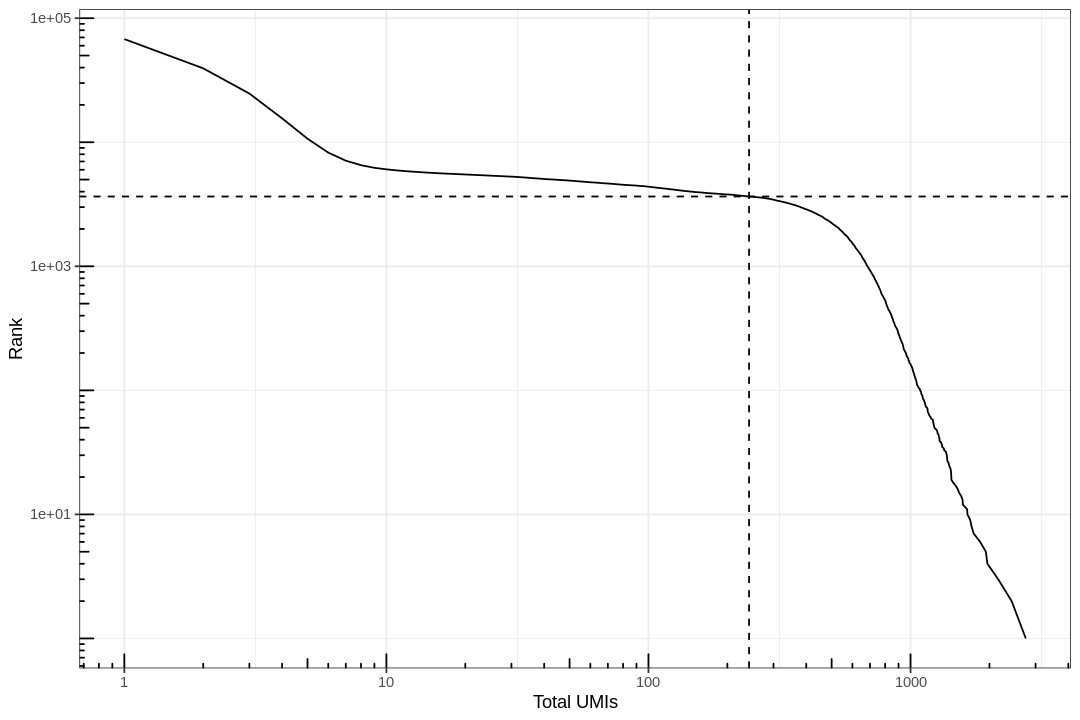

In [15]:
options(repr.plot.width=9, repr.plot.height=6)
knee_plot(bc_rank)

In [16]:
res_mat <- res_mat[, tot_counts > metadata(bc_rank)$inflection]
res_mat <- res_mat[Matrix::rowSums(res_mat) > 0,]
dim(res_mat)

[1] 21574  3655

### Visualizing count distributions

Percentage of transcripts from mitochondrially encoded genes

In [17]:
tr2g <- read_tsv("t2g.txt", col_names = c("transcript", "gene", "gene_symbol")) %>%
  select(-transcript) %>%
  distinct()

Parsed with column specification:
cols(
  transcript = col_character(),
  gene = col_character(),
  gene_symbol = col_character()
)



In [0]:
# Convert from Ensembl gene ID to gene symbol
rownames(res_mat) <- tr2g$gene_symbol[match(rownames(res_mat), tr2g$gene)]

In [19]:
seu <- CreateSeuratObject(res_mat, min.cells = 3, min.features = 200)

Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”


In [0]:
seu[["percent.mt"]] <- PercentageFeatureSet(seu, pattern = "^mt-")

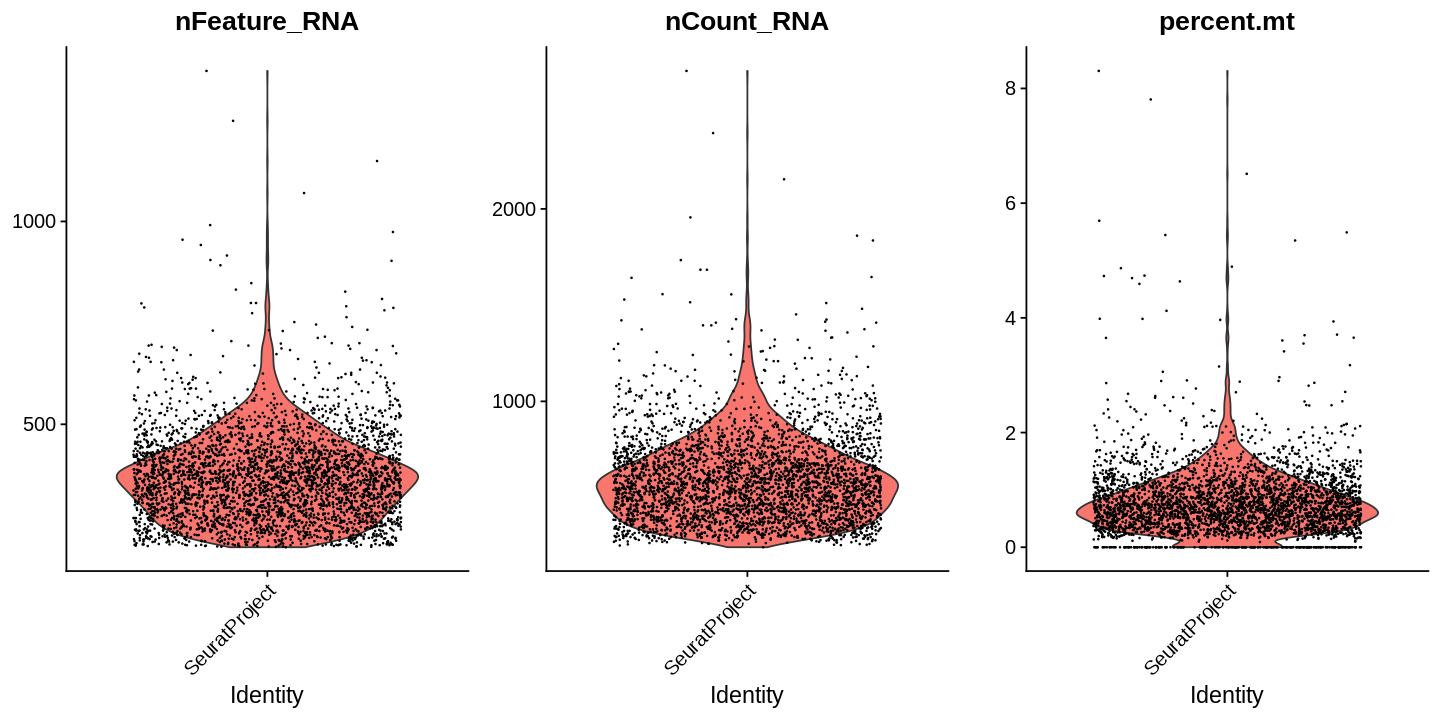

In [21]:
# Visualize QC metrics as a violin plot
options(repr.plot.width=12, repr.plot.height=6)
VlnPlot(seu, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, pt.size = 0.1)

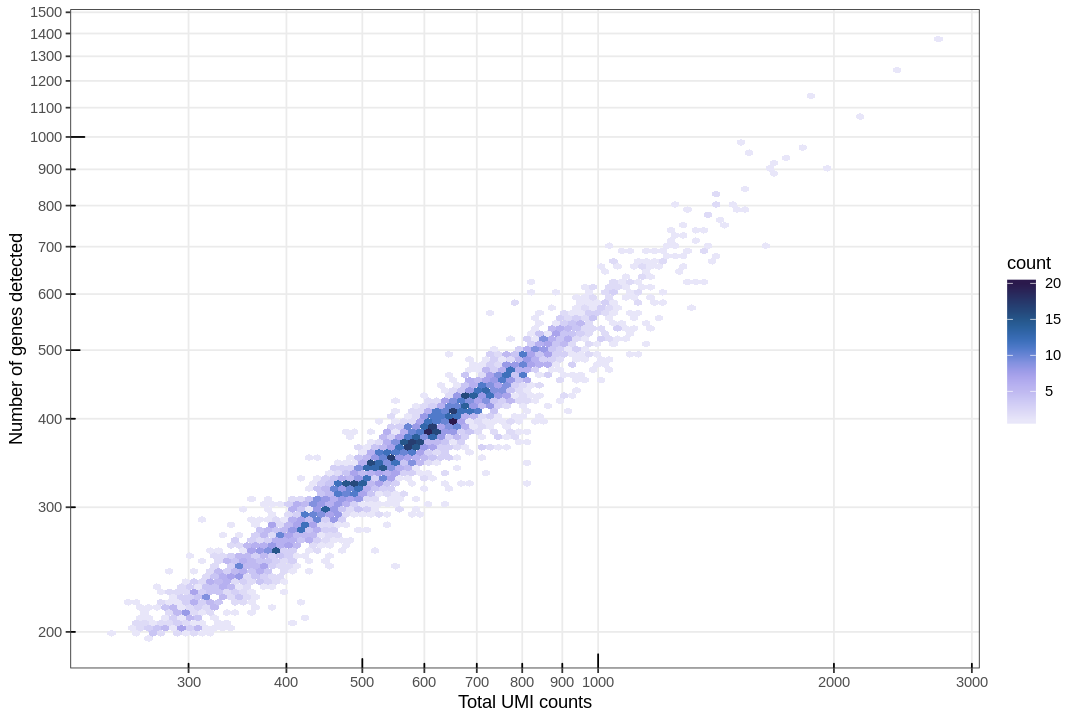

In [22]:
options(repr.plot.width=9, repr.plot.height=6)
ggplot(seu@meta.data, aes(nCount_RNA, nFeature_RNA)) +
  geom_hex(bins = 100) +
  scale_fill_scico(palette = "devon", direction = -1, end = 0.9) +
  scale_x_log10(breaks = breaks_log(12)) + 
  scale_y_log10(breaks = breaks_log(12)) + annotation_logticks() +
  labs(x = "Total UMI counts", y = "Number of genes detected") +
  theme(panel.grid.minor = element_blank())

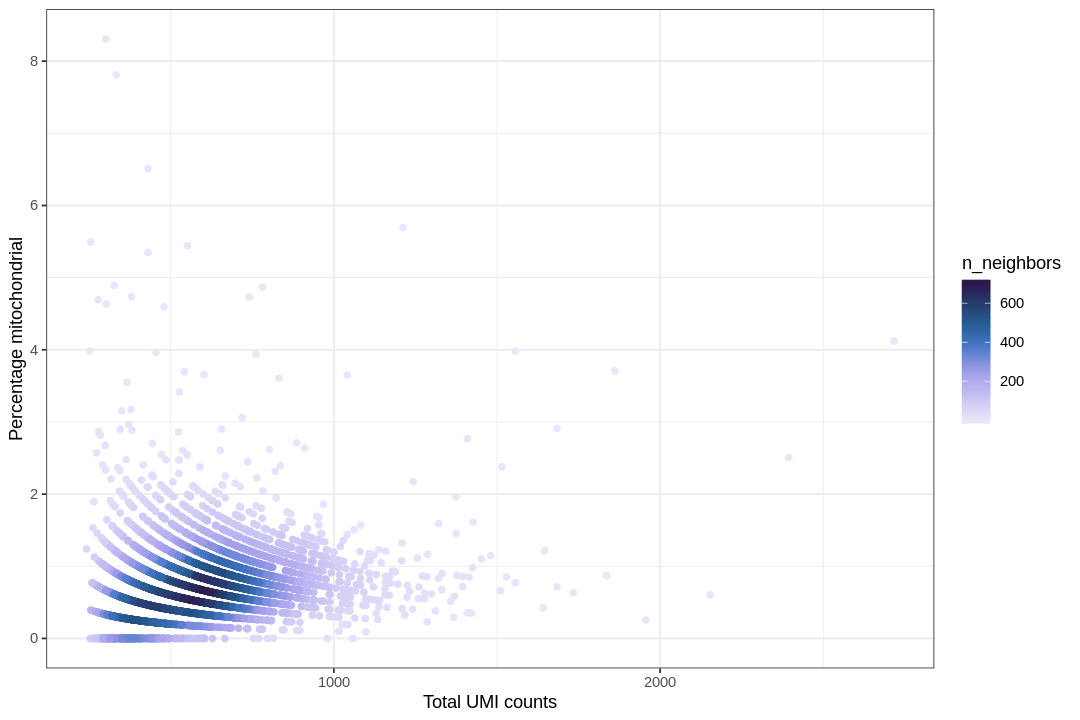

In [23]:
ggplot(seu@meta.data, aes(nCount_RNA, percent.mt)) +
  geom_pointdensity() +
  scale_color_scico(palette = "devon", direction = -1, end = 0.9) +
  labs(x = "Total UMI counts", y = "Percentage mitochondrial")

The color shows density of points, as the density is not apparent when many points are stacked on top of each other. Cells with high percentage of mitochondrially encoded transcripts are often removed in QC, as those are likely to be low quality cells. If a cell is lysed in sample preparation, transcripts in the mitochondria are less likely to be lost than transcripts in the cytoplasm due to the double membrane of the mitochondria, so cells that lysed tend to have a higher percentage of mitochondrially encoded transcripts.

We filter cells with more than 3% mitochondrial content based on the plot above.

In [0]:
seu <- subset(seu, subset = percent.mt < 3)

In [25]:
seu <- NormalizeData(seu) %>% ScaleData()

Centering and scaling data matrix



## Analysis

### Identify highly variable genes

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”
When using repel, set xnudge and ynudge to 0 for optimal results



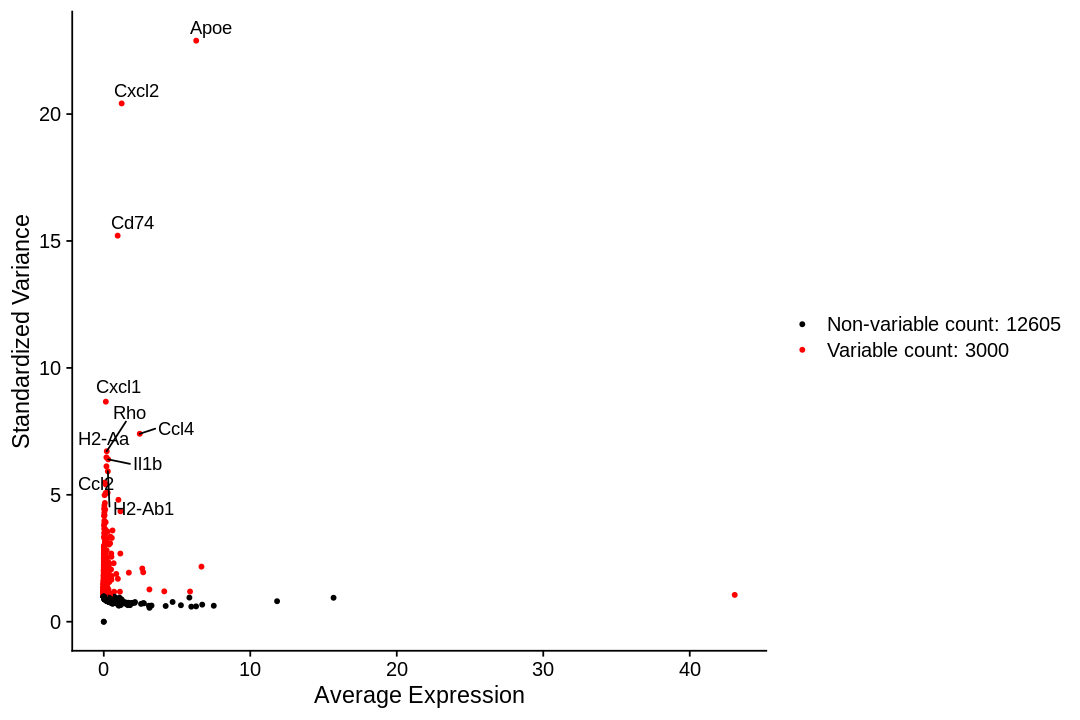

In [26]:
seu <- FindVariableFeatures(seu, nfeatures = 3000)
top10 <- head(VariableFeatures(seu), 10)
plot1 <- VariableFeaturePlot(seu, log = FALSE)
LabelPoints(plot = plot1, points = top10, repel = TRUE)

### PCA

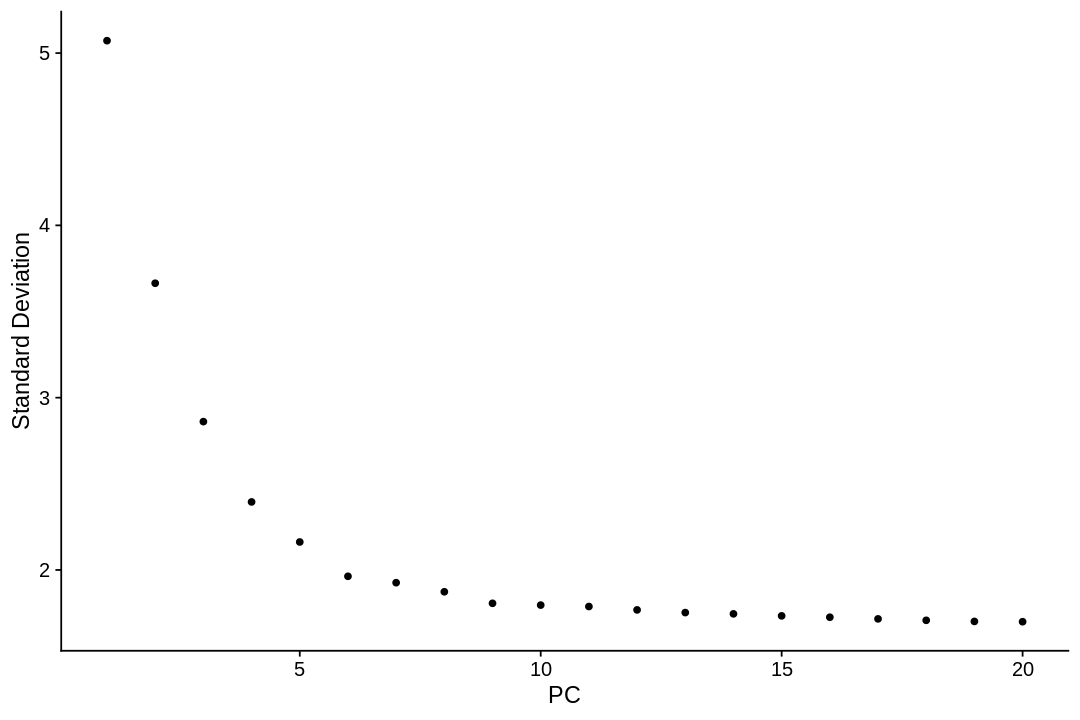

In [27]:
seu <- RunPCA(seu, verbose = FALSE, npcs = 20) # uses HVG by default
ElbowPlot(seu, ndims = 20)

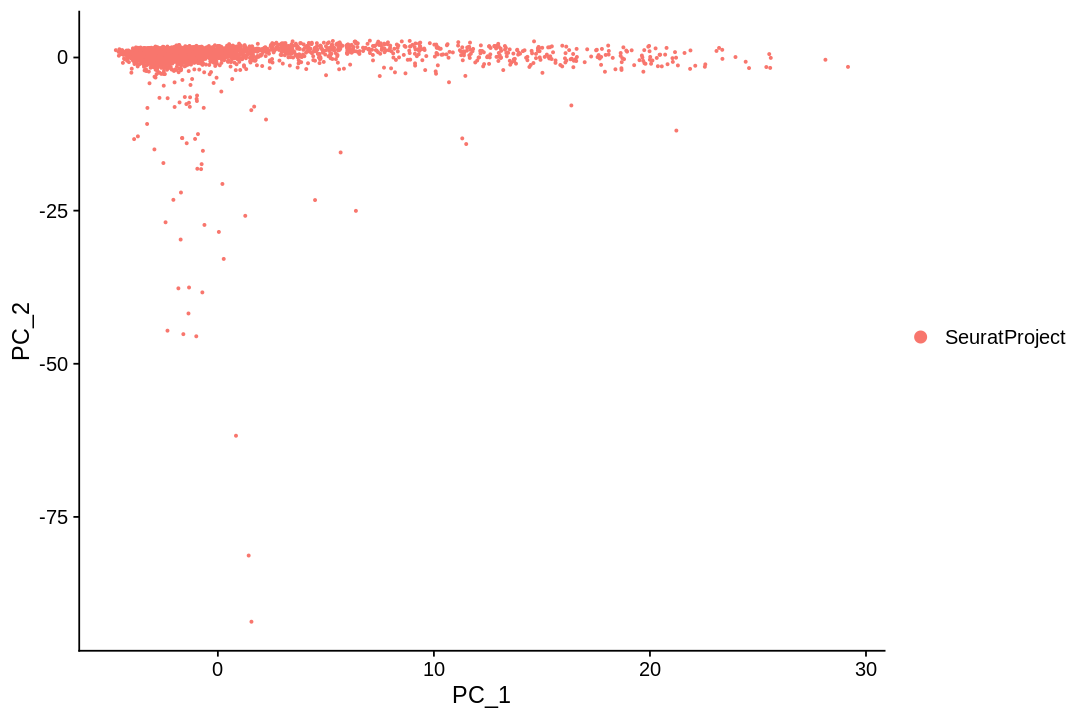

In [28]:
PCAPlot(seu)

### Clustering and visualization

There are many algorithms for clustering cells, and while they have been compared in detail in various benchmarks (see e.g., [Duo et al. 2018](https://f1000research.com/articles/7-1141/v2)), there is no univerally agreed upon method. Here we demonstrate clustering using [Louvain clustering](https://en.wikipedia.org/wiki/Louvain_modularity), which is a popular method for clustering single-cell RNA-seq data. The method was published in 

- Blondel, Vincent D; Guillaume, Jean-Loup; Lambiotte, Renaud; Lefebvre, Etienne (9 October 2008). "Fast unfolding of communities in large networks". Journal of Statistical Mechanics: Theory and Experiment. 2008 (10): P10008.

In [29]:
seu <- FindNeighbors(seu, dims = 1:10)
seu <- FindClusters(seu)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3507
Number of edges: 112345

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7194
Number of communities: 8
Elapsed time: 0 seconds


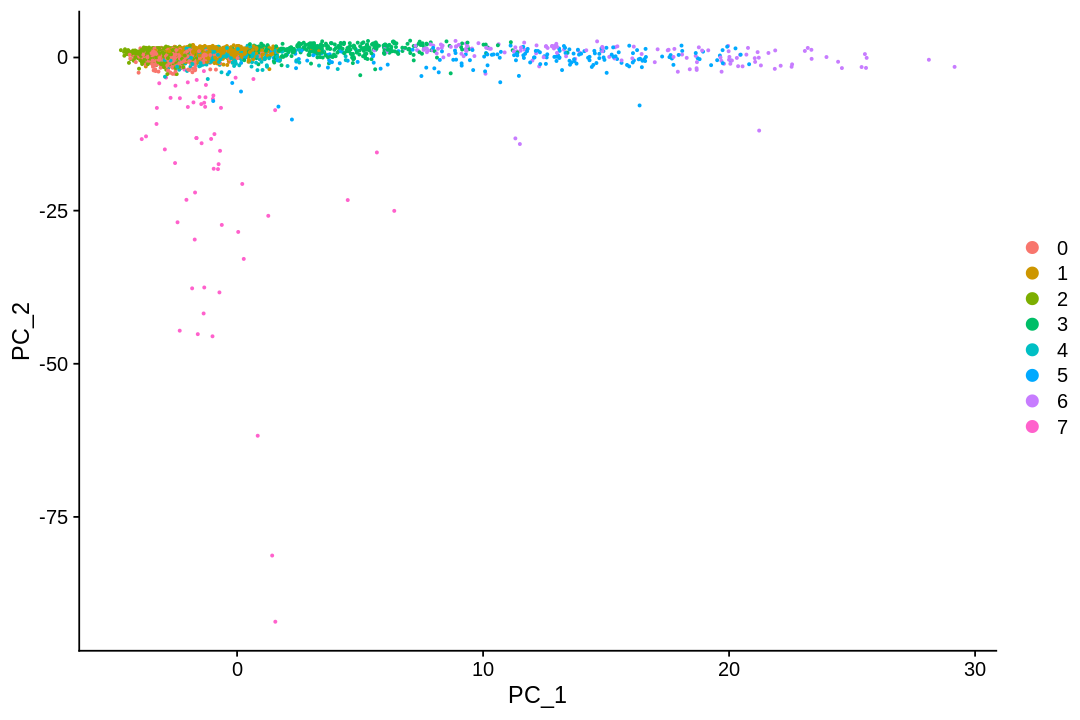

In [30]:
PCAPlot(seu)

### tSNE

[t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) is a non-linear dimensionality reduction technique described in:

- Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of machine learning research 9.Nov (2008): 2579-2605.

Here it is applied to the 10-dimensional PCA projection of the cells.


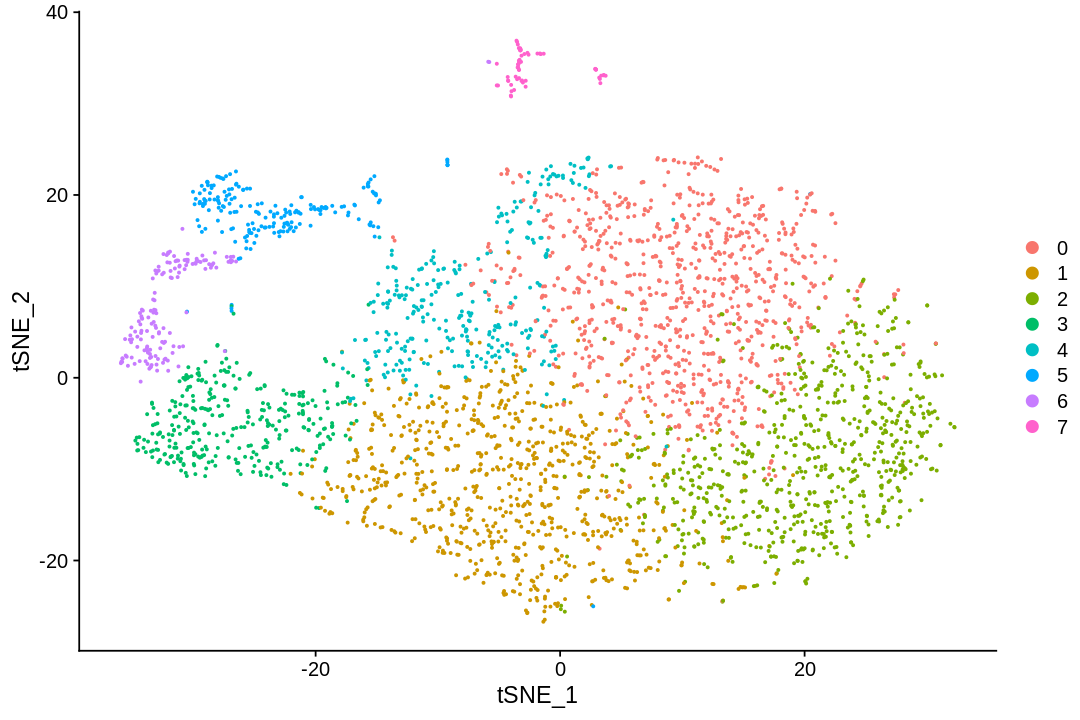

In [31]:
seu <- RunTSNE(seu, dims = 1:10)
TSNEPlot(seu)

### UMAP

UMAP (UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction) is a manifold learning technique that can also be used to visualize cells. It was published in:

- McInnes, Leland, John Healy, and James Melville. "Umap: Uniform manifold approximation and projection for dimension reduction." arXiv preprint arXiv:1802.03426 (2018).


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


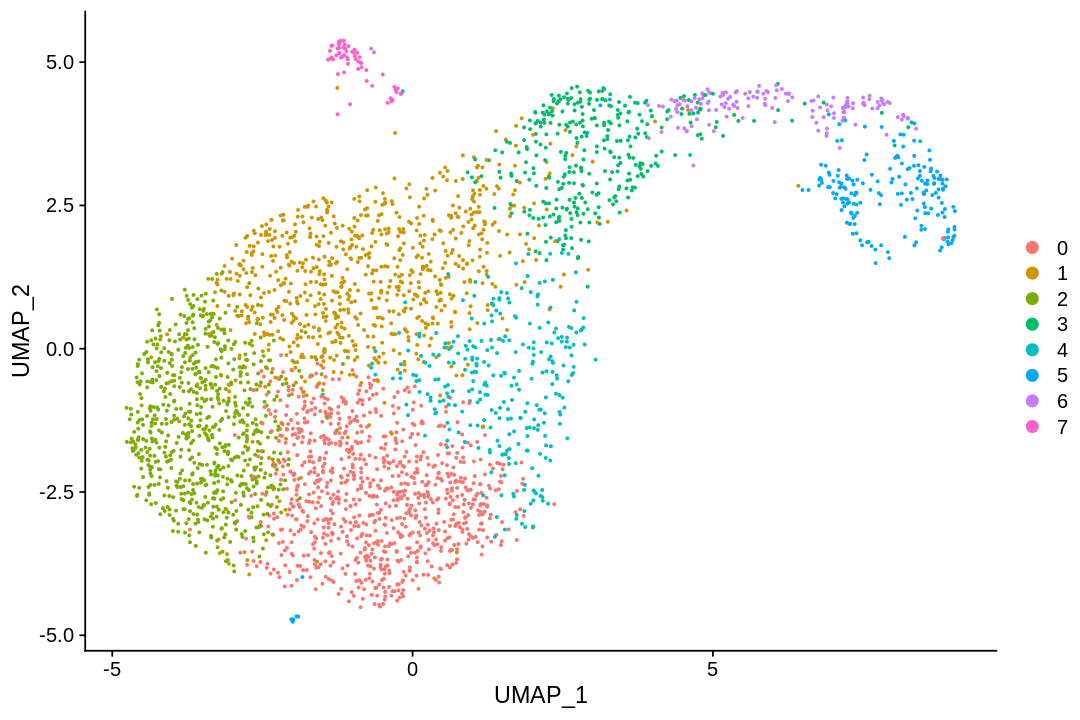

In [32]:
seu <- RunUMAP(seu, dims = 1:10, verbose = FALSE)
UMAPPlot(seu)

# Discussion

This notebook has demonstrated visualization of cells following pre-processing of single-cell RNA-seq data.

In [33]:
Sys.time() - start_time

Time difference of 34.70659 mins

Installing packages took about 26 minutes, which is a drawback of Rcpp. The QC and  analysis post-installation takes about 10 minutes from reads to results. This includes downloading the data, filtering, clustering and visualization.

**Feedback**: please report any issues, or submit pull requests for improvements, in the [Github repository where this notebook is located](https://github.com/pachterlab/kallistobustools/blob/master/notebooks/kb_intro_2_R.ipynb).